In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

['400860-400861', '400861-403781', '400861-405376', '403781-400948', '403781-403047', '405376-401305']
{'403781-403047': ['400861-403781'], '403781-400948': ['400861-403781'], '400860-400861': ['400861-403781', '400861-405376'], '400861-403781': ['400860-400861', '403781-400948', '403781-403047'], '400861-405376': ['400860-400861', '405376-401305'], '405376-401305': ['400861-405376']}
cuda:1


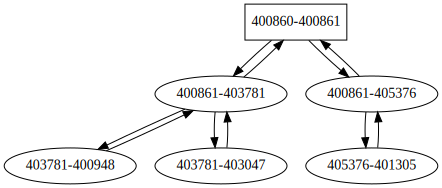

In [3]:
SROUTE, ADJ = read_graph('graphs/400860_n3.json')
graph = show_graph(SROUTE, ADJ)

DENSE = False
EPS = 120
LAG = 24 + 1
HSIZE = 128
STOPS = len(SROUTE)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
graph

In [4]:
dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
evalset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10).generator()

Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
    * [400861-403781]: 90
    * [400861-405376]: 90
    * [403781-400948]: 90
    * [403781-403047]: 90
    * [405376-401305]: 90
 [*] Examples (train): 6036
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
    * [400861-403781]: 90
    * [400861-405376]: 90
    * [403781-400948]: 90
    * [403781-403047]: 90
    * [405376-401305]: 90
 [*] Examples (test): 1320
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [5]:
from models.temporal.RNN import *
from models.MPRNN import *

model = MPRNN(
    nodes=SROUTE, adj=ADJ, 
    hidden_size=HSIZE, 
    
    rnnmdl=RNN_MIN,
    mpnmdl=MP_DENSE,
    
    verbose=True).to(device)
model.device = device

MPRNN
 [*] Defined over: 6 nodes
 [*] Contains    : 6 adjs


In [6]:
criterion, opt, sch = model.params(lr=0.01)

In [7]:
model.clear_stats()
evf = lambda: evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())
_ = evf()

Eval loss: 82.2409           


In [14]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    bls = []
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        bls.append(loss.item())
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            '(avg %.2f)' % (10 ** 2 * np.mean(bls)) if bii == len(dset) -1 else ''
        ))
    sys.stdout.write('\n')

    eval_mse.append(evf())
    sys.stdout.flush()
    sch.step()

[1/120 : 230/230] - L0.18 (avg 0.19)      
Eval loss: 0.17240           
[2/120 : 230/230] - L0.16 (avg 0.19)      


Process Process-495:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-496:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 104, in get
    if timeout < 0 or not self._poll(timeout):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dat

KeyboardInterrupt: 

0.1737723711108708


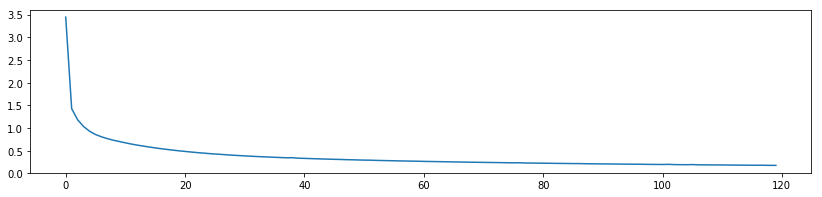

In [7]:
print(eval_mse[-1])
plt.figure(figsize=(14, 3))
plt.plot(eval_mse)
plt.show(); plt.close()

In [8]:
from utils import *
viewset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=False)
def xfmt(datain):
    bynode = torch.split(datain.to(device).float().unsqueeze(1), 1, 2)
    return bynode

In [9]:
# torch.save(model.state_dict(), 'checkpoints/mpnn_n3.pth')
# torch.save(model, 'checkpoints/mpnn_n3_full.pth')
# model = torch.load('checkpoints/mpnn_n3_full.pth')

Eval segments: 18
Eval MSE: 0.2565


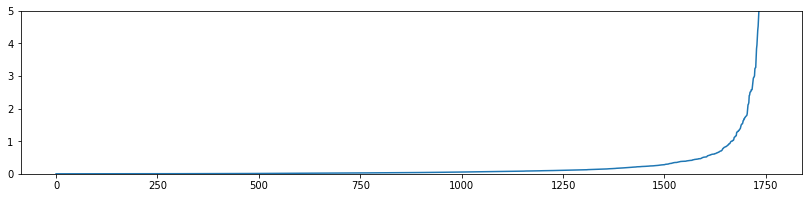

In [10]:
model.steps = len(SROUTE)
sqerr = eval_rnn(viewset, model, plot=False, xfmt=xfmt)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

plt.figure(figsize=(14, 3))
plt.plot(sorted(sqerr)); plt.ylim(0, 5)
plt.show(); plt.close()

Conditional Forecast


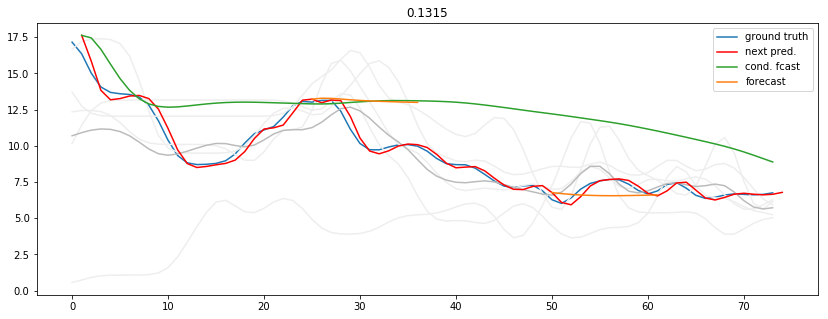

Conditional Forecast


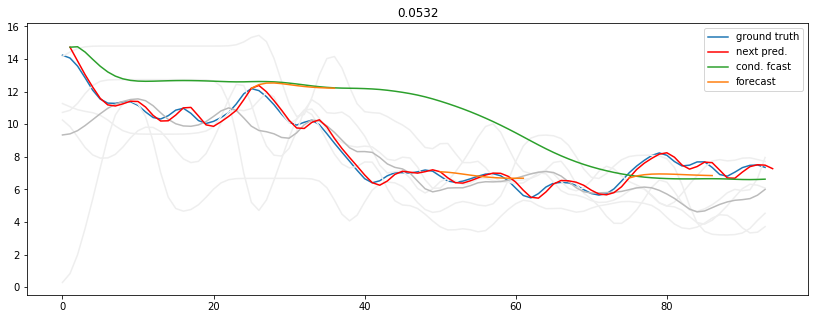

Conditional Forecast


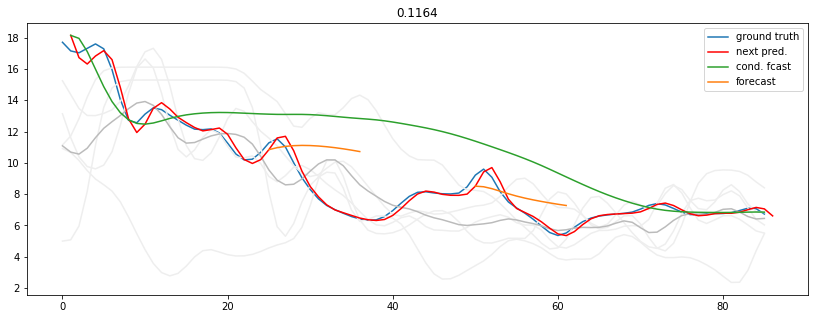

In [11]:
_ = eval_rnn(
    viewset[:3], model, 
    flag=LAG, fmax=12,
    xfmt=xfmt,
    plot=True)

In [23]:
for kk in model.state_dict().keys():
    print(kk)

rnns.0.inp.0.weight
rnns.0.inp.0.bias
rnns.0.out.0.weight
rnns.0.out.0.bias
rnns.0.rnn.weight_ih_l0
rnns.0.rnn.weight_hh_l0
rnns.0.rnn.bias_ih_l0
rnns.0.rnn.bias_hh_l0
rnns.1.inp.0.weight
rnns.1.inp.0.bias
rnns.1.out.0.weight
rnns.1.out.0.bias
rnns.1.rnn.weight_ih_l0
rnns.1.rnn.weight_hh_l0
rnns.1.rnn.bias_ih_l0
rnns.1.rnn.bias_hh_l0
rnns.2.inp.0.weight
rnns.2.inp.0.bias
rnns.2.out.0.weight
rnns.2.out.0.bias
rnns.2.rnn.weight_ih_l0
rnns.2.rnn.weight_hh_l0
rnns.2.rnn.bias_ih_l0
rnns.2.rnn.bias_hh_l0
mpns.0.msg_op.0.weight
mpns.0.msg_op.0.bias
mpns.0.msg_op.2.weight
mpns.0.msg_op.2.bias
mpns.0.upd_op.0.weight
mpns.0.upd_op.0.bias
mpns.0.upd_op.2.weight
mpns.0.upd_op.2.bias
mpns.1.msg_op.0.weight
mpns.1.msg_op.0.bias
mpns.1.msg_op.2.weight
mpns.1.msg_op.2.bias
mpns.1.upd_op.0.weight
mpns.1.upd_op.0.bias
mpns.1.upd_op.2.weight
mpns.1.upd_op.2.bias
mpns.2.msg_op.0.weight
mpns.2.msg_op.0.bias
mpns.2.msg_op.2.weight
mpns.2.msg_op.2.bias
mpns.2.upd_op.0.weight
mpns.2.upd_op.0.bias
mpns.2.upd_o

In [16]:
# torch.save(model, 'checkpoints/mpnn_thin_n3.pth')